In [1]:
import os, pickle
import numpy as np
import plot_tools as pt
import matplotlib.pylab as plt

In [2]:
# building the dataset
DATASET = {'mice':[],
           'days':[],
           'folders':[]}

data_folder = os.path.join(os.path.expanduser('~'), 'DATA', 'Marcel_Data')
days = [d for d in os.listdir(data_folder) if (('._' not in d) and ('.DS' not in d))]
for day in days:
    mice = [f for f in os.listdir(os.path.join(data_folder, day)) if '.DS' not in f]
    for m in mice:
        folders = [f for f in os.listdir(os.path.join(data_folder, day, m)) if '.DS' not in f]
        for f in folders:
            DATASET['mice'].append(m)
            DATASET['days'].append(day)
            DATASET['folders'].append(os.path.join(data_folder, day, m, f))

In [3]:
DATASET['with_whisking'] = np.zeros(len(DATASET['days']), dtype=bool)
for i, f in enumerate(DATASET['folders']):
    with open(os.path.join(f, 'Analysis_Data.pickle'), 'rb') as f:
        try:
            data = pickle.load(f)
            if ('Whisking_data' in data) and ('lmi' in data):
                DATASET['with_whisking'][i] = True
        except BaseException:
            print('pb with', i, f)

print('N=%i sessions with whisking data' % np.sum(DATASET['with_whisking']))

N=85 sessions with whisking data


In [13]:
def load_data(f):
    with open(os.path.join(f, 'Analysis_Data.pickle'), 'rb') as F:
        data = pickle.load(F)
    return data.copy()

def apply_min_duration(time, array,
                       duration=0.5):
    array[0] = False
    array[-1] = False
    up = np.flatnonzero(~array[:-1] & array[1:])
    down = np.flatnonzero(array[:-1] & ~array[1:])
    for i0, i1 in zip(up, down):
        if (time[i1]-time[i0])<0.5:
            array[i0:i1] = False

def fetch_all(data):
    
    time = np.linspace(0, data['Settings']['time_seconds'], len(data['Locomotion_data']['speed']))
    
    whisking = np.zeros(len(time), dtype=bool)
    for i in data['Whisking_data']['location_bouts']:
        whisking[i[0]:i[1]] = True
        
    running = np.zeros(len(time), dtype=bool)
    for i in data['Locomotion_data']['events']['location']:
        running[i[0]:i[1]] = True

    # whisking only
    whisk_only = np.zeros(len(time), dtype=bool)
    if len(data['Whisking_data']['whisking only'])>0:
        for i in data['Whisking_data']['whisking only']['bout_location']:
            whisk_only[i[0]:i[1]] = True

    # running only
    run_only  = running & (~whisking)
    apply_min_duration(time, run_only)
    
    return running, whisking, running & whisking, run_only, whisk_only

data = load_data('/Users/yann/DATA/Marcel_Data/2021.08.16/M_130/TSeries-08162021-1650-005')
print(data['Whisking_data']['whisking only'])
running, whisking, run_whisk, run_only, whisk_only = fetch_all(data)

[]


In [16]:
RESULTS = {'running':[], 'whisking':[],
           'run_whisk':[], 
           'run_only':[], 'whisk_only':[]} 
for i, f in enumerate(np.array(DATASET['folders'])[DATASET['with_whisking']]):

    data = load_data(f)
    
    running, whisking, run_whisk, run_only, whisk_only = fetch_all(data)
    
    RESULTS['running'].append(np.sum(running)/len(running))
    RESULTS['whisking'].append(np.sum(whisking)/len(running))
    RESULTS['run_whisk'].append(np.sum(run_whisk)/len(running))
    RESULTS['run_only'].append(np.sum(run_only)/len(running))
    RESULTS['whisk_only'].append(np.sum(whisk_only)/len(running))

running : 0.320 +/- 0.015 or 0.135 
whisking : 0.465 +/- 0.024 or 0.216 
run_whisk : 0.289 +/- 0.015 or 0.138 
run_only : 0.016 +/- 0.002 or 0.023 
whisk_only : 0.147 +/- 0.017 or 0.157 


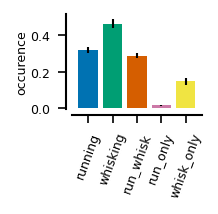

In [17]:
from scipy import stats
fig, ax = pt.figure()
for i, key in enumerate(RESULTS):
    print('%s : %.3f +/- %.3f or %.3f ' % (key, np.mean(RESULTS[key]), stats.sem(RESULTS[key]), np.std(RESULTS[key])))
    ax.bar([i], [np.mean(RESULTS[key])], yerr=[stats.sem(RESULTS[key])])
pt.set_plot(ax,
            xticks = range(i+1), xticks_labels=list(RESULTS.keys()),
            fontsize=6, xticks_rotation=70, ylabel='occurence')

In [18]:
LMIs, WMIs, WOMIs, n = [], [], [], 0

for i, f in enumerate(np.array(DATASET['folders'])[DATASET['with_whisking']]):
    with open(os.path.join(f, 'Analysis_Data.pickle'), 'rb') as F:
        data = pickle.load(F)
        if 'WMI dF' in data['table_data']:
            WMIs += list(np.array(data['table_data']['WMI dF'], dtype=float))
        else:
            print('no Whisking for: ', f)
        if 'WOMI dF' in data['table_data']:
            WOMIs += list(np.array(data['table_data']['WOMI dF'], dtype=float))
        else:
            print('no Whisking-Only for: ', f)
        if 'lmi' in data:
            LMIs += data['lmi']
            n+=1
        else:
            print('no Locomotion for: ', f)
            
print('N=%i sessions' % n )

no Whisking-Only for:  /Users/yann/DATA/Marcel_Data/2021.08.16/M_130/TSeries-08162021-1650-005
no Whisking-Only for:  /Users/yann/DATA/Marcel_Data/2021.02.25/M_106/TSeries-02252021-1557-005
N=85 sessions


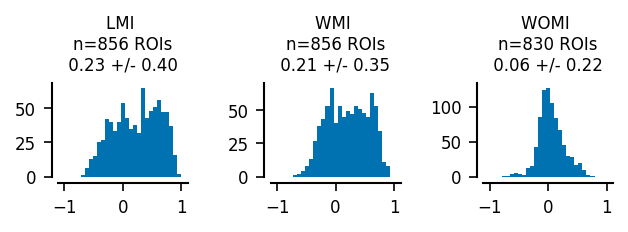

In [19]:
fig, AX = pt.figure(axes=(3,1))
for ax, MIs, title in zip(AX, [LMIs, WMIs, WOMIs], ['LMI', 'WMI', 'WOMI']):
    ax.hist(MIs, bins=np.linspace(-1,1,30))
    pt.set_plot(ax, xticks=[-1,0,1],
                title='%s \nn=%i ROIs\n %.2f +/- %.2f ' % (title, len(MIs), np.mean(MIs), np.std(MIs)))

In [20]:
with open('table.csv', 'w',) as file:
    file.write("LMI, WMI, WOMI")
    
    for i in range(len(LMIs)):
        line = ''
        line += '%.6f, ' % LMIs[i] 
        line += '%.6f, ' % WMIs[i] 
        if i<(len(WOMIs)-1):
            line += '%.6f,' % WOMIs[i] 
        file.write(line+'\n')